## Compile Figure 1

Figure 1 introduces grit and demonstrates utility.
Figure 1 contains 5 panels.

1. Panel A - A brief visualization of motivation and calculation
2. Panel B - Distribution of grit scores in the Cell Health dataset
3. Panel C - Comparison of CERES and grit scores
4. Panel D - Grit prioritization compared to control and replicate correlations
5. Panel E - Single Cell grit

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(magick))

In [2]:
# Set file names
output_dir <- "figures"

cell_health_dir <- file.path("../1.calculate-metrics/cell-health/results")
ceres_dir <- file.path("../2.compare-metrics/cell-health/results")

grit_file <- file.path(cell_health_dir, "cell_health_grit.tsv")
non_replicate_cor_file <- file.path(cell_health_dir, "cell_health_nonreplicate_95thpercentile.tsv")
reprod_file <- file.path(cell_health_dir, "cell_health_replicate_reproducibility.tsv")
ceres_file <- file.path(ceres_dir, "cell_health_grit_ceres.tsv")

# Model predictions
commit <- "7d63d4a43014c757fd0c77c0fd1c19540f17cc3d"
count_file <- paste0("https://raw.githubusercontent.com/broadinstitute/cell-health/", commit, "/1.generate-profiles/tables/cell_count_summary.tsv")

sc_plate <- "SQ00014613"
sc_grit_file <- file.path(cell_health_dir, paste0("cellhealth_single_cell_grit_", sc_plate, ".tsv.gz"))
sc_umap_file <- file.path(cell_health_dir, paste0("cellhealth_single_cell_umap_embeddings_", sc_plate, ".tsv.gz"))

In [3]:
# Load data
grit_cols <- readr::cols(
    perturbation = readr::col_character(),
    group = readr::col_character(),
    grit = readr::col_double(),
    cell_line = readr::col_character(),
    barcode_control = readr::col_character(),
    cor_method = readr::col_character()
)

non_rep_cols <- readr::cols(
    cell_line = readr::col_character(),
    similarity_metric = readr::col_double()
)

rep_cols <- readr::cols(
    cell_line = readr::col_character(),
    group = readr::col_character(),
    perturbation = readr::col_character(),
    median_replicate_correlation = readr::col_double(),
    median_control_correlation = readr::col_double()
)

count_cols <- readr::cols(
    gene_name = readr::col_character(),
    pert_name = readr::col_character(),
    cell_line = readr::col_character(),
    cell_count = readr::col_double()
)

ceres_cols <- readr::cols(
    perturbation = readr::col_character(),
    group = readr::col_character(),
    grit = readr::col_double(),
    cell_line = readr::col_character(),
    barcode_control = readr::col_character(),
    cor_method = readr::col_character(),
    query = readr::col_character(),
    `_id` = readr::col_double(),
    DepMap_ID = readr::col_character(),
    stripped_cell_line_name = readr::col_character(),
    ceres_score = readr::col_double(),
    grit_mean = readr::col_double()
)

grit_df <- readr::read_tsv(grit_file, col_types = grit_cols)
nonrep_df <- readr::read_tsv(non_replicate_cor_file, col_types = non_rep_cols)
rep_df <- readr::read_tsv(reprod_file, col_types = rep_cols)
count_df <- readr::read_tsv(count_file, col_types = count_cols)
ceres_df <- readr::read_tsv(ceres_file, col_types = ceres_cols)

In [4]:
# Load single cell data
sc_grit_cols <- readr::cols(
    perturbation = readr::col_character(),
    group = readr::col_character(),
    grit = readr::col_double(),
    gene = readr::col_character(),
    guide = readr::col_character(),
    grit_gene = readr::col_character(),
    grit_guide = readr::col_character()
)

sc_umap_cols <- readr::cols(
    Metadata_cell_identity = readr::col_character(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_gene_name = readr::col_character(),
    Metadata_pert_name = readr::col_character(),
    Metadata_broad_sample = readr::col_character(),
    Metadata_cell_line = readr::col_character(),
    Metadata_TableNumber = readr::col_character(),
    Metadata_ImageNumber = readr::col_double(),
    Metadata_ObjectNumber_cytoplasm = readr::col_double(),
    Metadata_Cytoplasm_Parent_Cells = readr::col_double(),
    Metadata_Cytoplasm_Parent_Nuclei = readr::col_double(),
    Metadata_ObjectNumber_cells = readr::col_double(),
    Metadata_ObjectNumber = readr::col_double(),
    umap_0 = readr::col_double(),
    umap_1 = readr::col_double(),
    grit_gene = readr::col_character()
)

sc_grit_df <- readr::read_tsv(sc_grit_file, col_types = sc_grit_cols)
sc_umap_df <- readr::read_tsv(sc_umap_file, col_types = sc_umap_cols)

In [5]:
# Set plotting constants
cell_line_colors <- c(
  "A549" = "#861613",
  "ES2" = "#1CADA8",
  "HCC44" = "#2A364D"
)

fig1_theme <- theme_bw() +
    theme(
        axis.title = element_text(size = 9),
        axis.text = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 8),
        strip.background = element_rect(color = "black", fill = "#fdfff4"),
        strip.text = element_text(size = 7)
    )

## Panel A

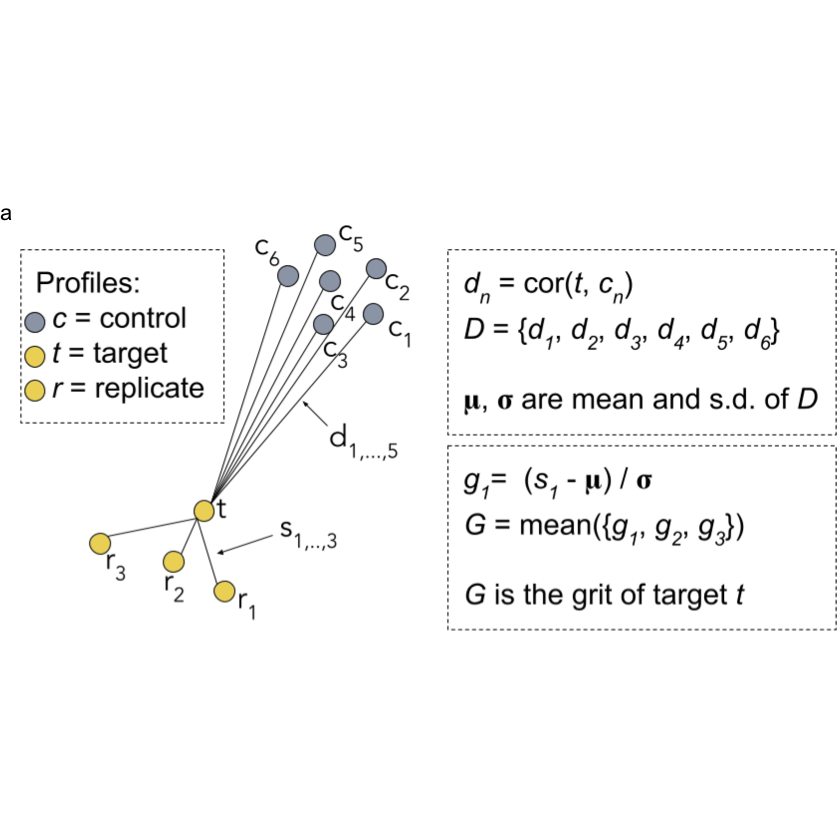

In [6]:
url <- "https://raw.githubusercontent.com/broadinstitute/grit-benchmark/2a4b0edc3d96b67b59d5071a4c3abb201725ac37/media/Figure1A_Simple_Interpretation.png"
panel_a_gg <- magick::image_ggplot(
    magick::image_scale(
        magick::image_read(url),
        "3500x3500"
    ), interpolate = TRUE
) + labs(tag = "a") + theme(plot.margin = unit(c(-10, 0, -10, 0), "cm"))

panel_a_gg

## Panel B

In [7]:
grit_focus_df <- grit_df %>%
    dplyr::filter(barcode_control == "cutting_control", cor_method == "pearson") %>%
    dplyr::left_join(rep_df, by = c("perturbation", "group", "cell_line")) %>%
    tidyr::drop_na()

head(grit_focus_df)

perturbation,group,grit,cell_line,barcode_control,cor_method,median_replicate_correlation,median_control_correlation
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
AKT1-1,AKT1,0.7939519,HCC44,cutting_control,pearson,0.3127380,-0.015761078
AKT1-2,AKT1,0.7758398,HCC44,cutting_control,pearson,0.1520556,0.007978621
ARID1B-1,ARID1B,0.4488762,HCC44,cutting_control,pearson,0.1868620,0.054083018
ARID1B-2,ARID1B,0.3234625,HCC44,cutting_control,pearson,0.2118464,0.033912054
ATF4-1,ATF4,0.2143735,HCC44,cutting_control,pearson,0.7549194,0.118991324
ATF4-2,ATF4,0.4731397,HCC44,cutting_control,pearson,0.2871017,0.031674428


In [8]:
mean_grit_df <- grit_focus_df %>%
    dplyr::group_by(cell_line) %>%
    dplyr::mutate(mean_grit = round(mean(grit), 3)) %>%
    dplyr::select(cell_line, mean_grit) %>%
    unique() %>%
    dplyr::ungroup() %>%
    dplyr::arrange(cell_line)

colnames(mean_grit_df) <- c("Cell line", "grit (mean)")

mean_grit_df

Cell line,grit (mean)
<chr>,<dbl>
A549,0.644
ES2,0.993
HCC44,0.946


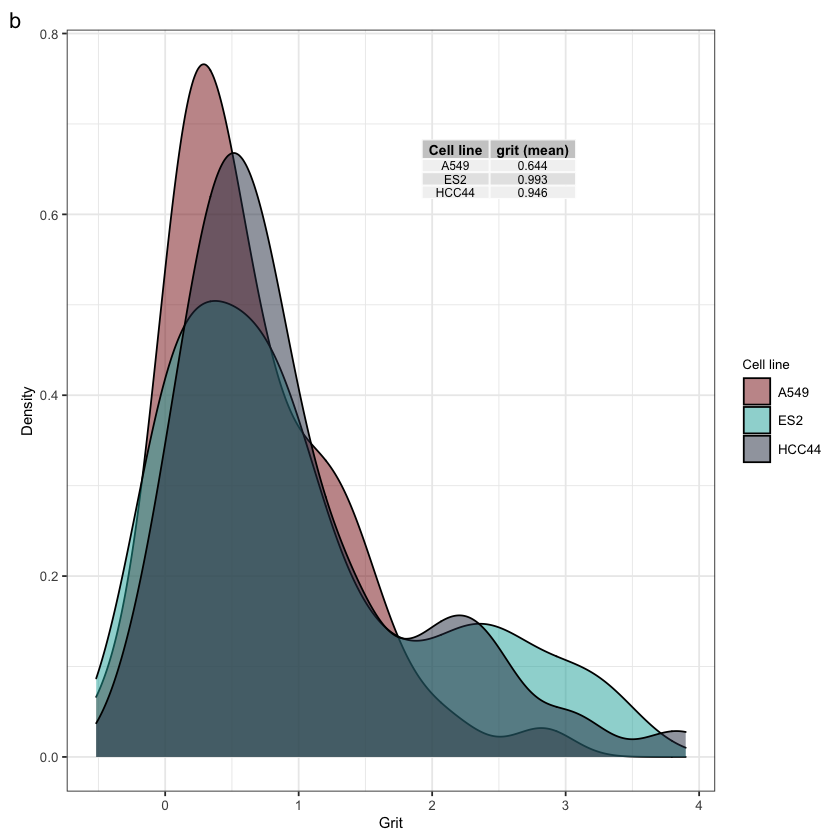

In [9]:
table_grob_theme <- gridExtra::ttheme_default(
    core = list(
        fg_params = list(cex = 0.6),
        padding = grid::unit.c(unit(1, "mm"), unit(1, "mm"))
    ),
    colhead = list(
        fg_params = list(cex = 0.7),
        padding = grid::unit.c(unit(3, "mm"), unit(2, "mm"))
        )
)

grit_mean_grob <- tableGrob(mean_grit_df, theme = table_grob_theme, rows = NULL)

mean_grit_gg <- (
    ggplot(grit_focus_df, aes(x = grit, fill = cell_line))
    + geom_density(alpha = 0.5)
    + scale_fill_manual(name = "Cell line", values = cell_line_colors)
    + annotation_custom(
        grit_mean_grob,
        xmin = 2,
        xmax = 3,
        ymin = 0.55,
        ymax = 0.75
    )
    + xlab("Grit")
    + ylab("Density")
    + fig1_theme
    + labs(tag = "b")
)

mean_grit_gg

## Panel C

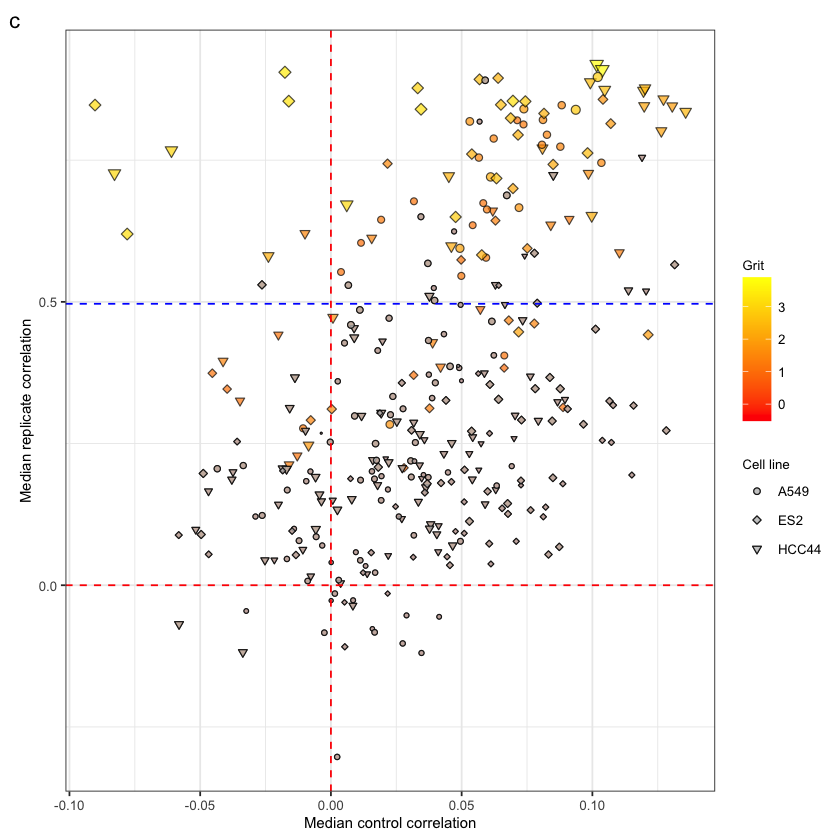

In [10]:
replicate_reprod_panel <- (
    ggplot(grit_focus_df, aes(x = median_control_correlation, y = median_replicate_correlation))
    + geom_point(
        aes(size = grit, fill = grit, shape = cell_line),
        alpha = 0.7
    )
    + geom_point(
        data = grit_focus_df %>% dplyr::filter(grit < 1),
        aes(size = grit, shape = cell_line),
        fill="grey",
        alpha = 0.8
    )
    + scale_fill_gradient(name = "Grit", high = "yellow", low = "red")
    + scale_shape_manual(name = "Cell line", values = c(21, 23, 25))
    + scale_size_continuous(guide = FALSE, range = c(0.2, 2.5))
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_hline(yintercept = 0, linetype = "dashed", color = "red")
    + geom_hline(yintercept = mean(nonrep_df$similarity_metric), linetype = "dashed", color = "blue")
    + ylab("Median replicate correlation")
    + xlab("Median control correlation")
    + fig1_theme
    + labs(tag = "c")
)

replicate_reprod_panel

## Panel D

In [11]:
ceres_figure_df <- ceres_df %>%
    dplyr::filter(barcode_control == "cutting_control", cor_method == "pearson") %>%
    dplyr::left_join(
        count_df,
        by = c("perturbation" = "pert_name", "group" = "gene_name", "cell_line" = "cell_line")
    )

head(ceres_figure_df)

perturbation,group,grit,cell_line,barcode_control,cor_method,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,grit_mean,cell_count
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
ITGAV-2,ITGAV,3.899438,HCC44,cutting_control,pearson,ITGAV,3685,ACH-000667,HCC44,-1.076603,3.642430,7099
ITGAV-1,ITGAV,3.775598,HCC44,cutting_control,pearson,ITGAV,3685,ACH-000667,HCC44,-1.076603,3.642430,7522
MYC-1,MYC,3.458591,ES2,cutting_control,pearson,MYC,4609,ACH-000906,ES2,-1.918112,3.429532,6006
MYC-2,MYC,3.264185,ES2,cutting_control,pearson,MYC,4609,ACH-000906,ES2,-1.918112,3.429532,8588
CCND1-2,CCND1,3.254757,ES2,cutting_control,pearson,CCND1,595,ACH-000906,ES2,-1.515170,2.688547,3021
CDK4-1,CDK4,3.243427,ES2,cutting_control,pearson,CDK4,1019,ACH-000906,ES2,-1.874398,2.821481,7026


Warning message:
“Removed 60 rows containing missing values (geom_point).”


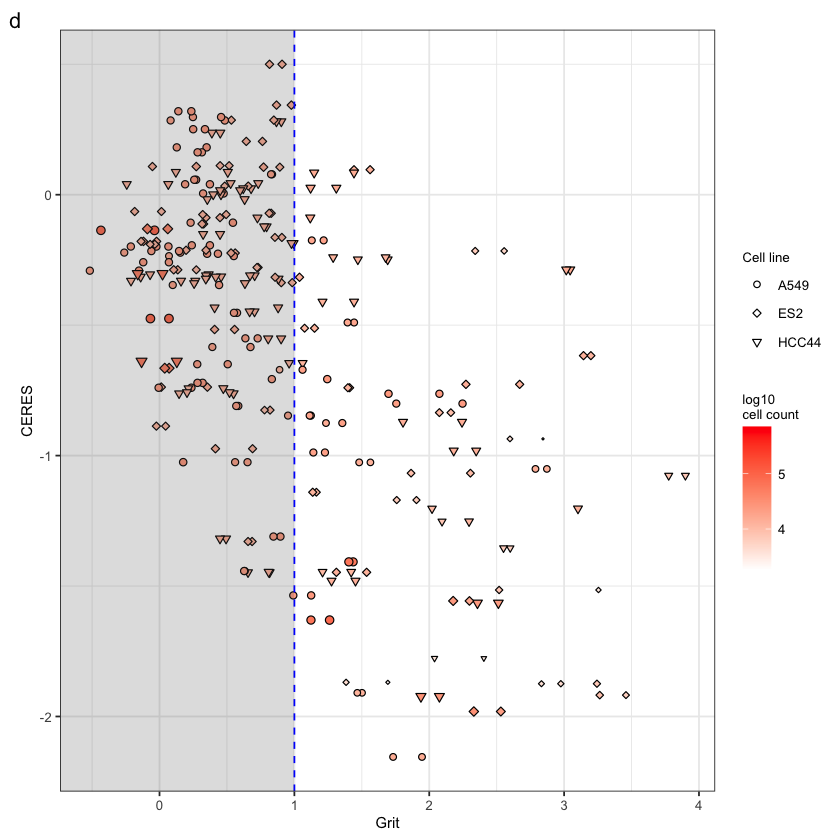

In [12]:
ceres_panel_gg = (
    ggplot(
        ceres_figure_df,
        aes(x = grit, y = ceres_score)
    )
    + geom_point(aes(fill = log10(cell_count), size = log10(cell_count), shape = cell_line))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "blue")
    + annotate("rect", xmin = -Inf, xmax = 1, ymin = -Inf, ymax = Inf, alpha = .2)
    + scale_shape_manual(name = "Cell line", values = c(21, 23, 25))
    + scale_fill_gradient(name = "log10\ncell count", low = "white", high = "red")
    + scale_size_continuous(guide = FALSE, range = c(0.2, 2.5))
    + xlab("Grit")
    + ylab("CERES")
    + fig1_theme
    + labs(tag = "d")
)

ceres_panel_gg

## Panel E

In [13]:
gene <- "ITGAV"

In [14]:
focus_plot_df <- sc_umap_df %>%
    dplyr::filter(grit_gene == !!gene) %>%
    dplyr::left_join(
        sc_grit_df %>%
            dplyr::filter(grit_gene == !!gene),
        by = c("Metadata_cell_identity" = "perturbation", "grit_gene" = "grit_gene")
    )

head(focus_plot_df)

Metadata_cell_identity,Metadata_Plate,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_TableNumber,Metadata_ImageNumber,Metadata_ObjectNumber_cytoplasm,⋯,Metadata_ObjectNumber_cells,Metadata_ObjectNumber,umap_0,umap_1,grit_gene,group,grit,gene,guide,grit_guide
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
cell_131426,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,1,⋯,1,1,1.980084,-0.2143344,ITGAV,ITGAV-1,0.2172438,ITGAV,ITGAV-1,ITGAV-1
cell_131427,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,2,⋯,2,2,1.782444,0.7633745,ITGAV,ITGAV-1,0.1804205,ITGAV,ITGAV-1,ITGAV-1
cell_131428,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,3,⋯,3,3,5.472637,4.5626700,ITGAV,ITGAV-1,0.7941470,ITGAV,ITGAV-1,ITGAV-1
cell_131429,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,4,⋯,4,4,4.775996,4.8649850,ITGAV,ITGAV-1,0.9498177,ITGAV,ITGAV-1,ITGAV-1
cell_131430,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,5,⋯,5,5,3.163316,4.6706440,ITGAV,ITGAV-1,0.9918295,ITGAV,ITGAV-1,ITGAV-1
cell_131431,SQ00014613,C19,ITGAV,ITGAV-1,BRDN0001052092,ES2,e83377b49494d1602acfccc8ea3a8e91,595,6,⋯,6,6,1.615719,3.3362334,ITGAV,ITGAV-1,1.0679619,ITGAV,ITGAV-1,ITGAV-1


In [15]:
control_perts <- focus_plot_df %>%
    dplyr::filter(Metadata_gene_name == "Chr2") %>%
    dplyr::select(Metadata_pert_name) %>%
    unique() %>%
    dplyr::pull(Metadata_pert_name)

gene_perts <- focus_plot_df %>%
    dplyr::filter(Metadata_gene_name == !!gene) %>%
    dplyr::select(Metadata_pert_name) %>%
    unique() %>%
    dplyr::pull(Metadata_pert_name)

pert_order <- c(gene_perts, sort(control_perts))

focus_plot_df$Metadata_pert_name <- factor(
    focus_plot_df$Metadata_pert_name, levels = pert_order
)

focus_plot_df <- focus_plot_df %>%
    dplyr::filter(Metadata_pert_name %in% pert_order)

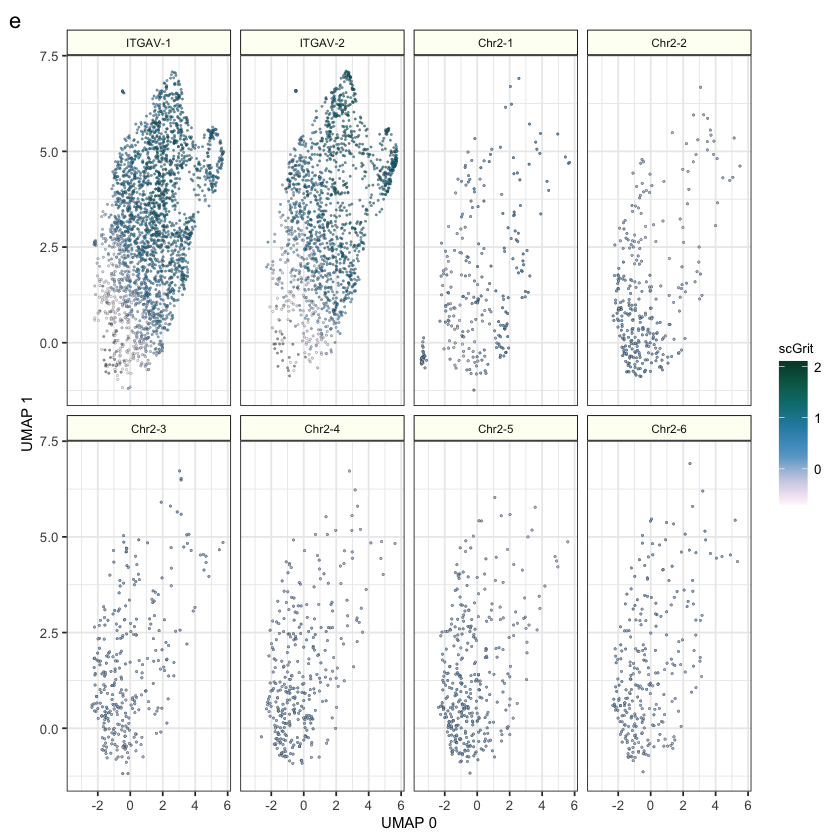

In [16]:
myPalette <- colorRampPalette(rev(brewer.pal(9, "PuBuGn")))

gene_umap_gg = (
    ggplot(focus_plot_df, aes(x = umap_0, y = umap_1))
    + geom_point(aes(fill = grit), pch = 21, size = 0.6, stroke = 0.1, alpha = 0.7)
    + facet_wrap("~Metadata_pert_name", nrow = 2)
    + scale_fill_gradientn(
        name = "scGrit",
        colors = myPalette(10),
        values = scales::rescale(c(2, 1.4, 1.1)),
        limits = c(-0.7, 2.1)
    )
    + xlab("UMAP 0")
    + ylab("UMAP 1")
    + fig1_theme
    + labs(tag = "e")
)

gene_umap_gg

Warning message:
“Removed 60 rows containing missing values (geom_point).”
Warning message:
“Removed 60 rows containing missing values (geom_point).”
Warning message:
“Removed 60 rows containing missing values (geom_point).”


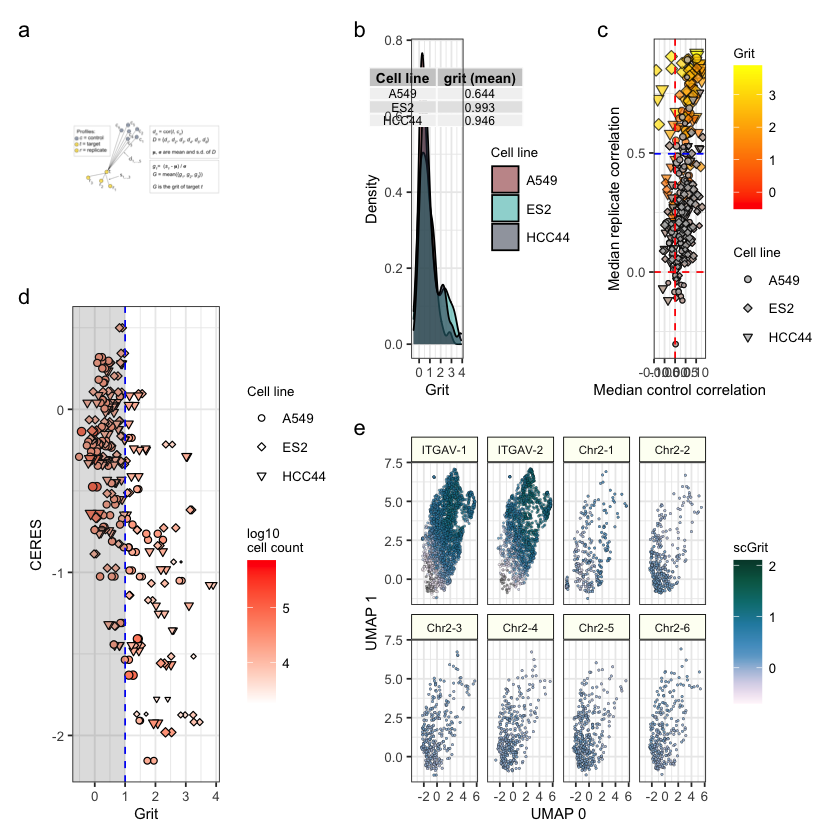

In [17]:
patchwork_plot <- (
    (
        panel_a_gg / ceres_panel_gg
    ) + plot_layout(heights = c(0.5, 1)) | (
        (
            mean_grit_gg + replicate_reprod_panel
        ) / gene_umap_gg
    )
) + plot_layout(widths = c(1, 2))


for (extension in c(".png", ".pdf")) {
    output_file <- file.path(output_dir, paste0("figure1", extension))
    ggsave(output_file, patchwork_plot, width = 12, height = 6.5)
}

patchwork_plot